In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import activations

import matplotlib as mpl
import pandas as pd

import seaborn as sns
sns.set()

import numpy as np

# from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Our Baseline model
from statsmodels.tsa.api import VAR

from statsmodels.tsa.stattools import adfuller,kpss

import matplotlib.pyplot as plt

#from scipy.stats import reciprocal
import pydot
import graphviz


from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error as mse

In [2]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [3]:
df_gdp=pd.read_csv(r".\datasets\Macroeconomic Data\A939RX0Q048SBEA.csv")
# real gdp per capita

df_urate=pd.read_csv(r".\datasets\Macroeconomic Data\UNRATE.csv")

#df_tedrate=pd.read_csv(r".\datasets\Macroeconomic Data\TEDRATE.csv")



In [4]:
#tscv = TimeSeriesSplit(test_size=1,n_splits=6)
#for train_index, test_index in tscv.split(df_data):
    #print("TRAIN:", train_index, "TEST:", test_index)
#    tr_ind=train_index
#    ts_ind=
#    break


In [5]:
df_data=df_urate.merge(df_gdp,how="inner",on="DATE")
df_data.rename({"A939RX0Q048SBEA":"GDP"},axis=1,inplace=True)

In [6]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295 entries, 0 to 294
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    295 non-null    object 
 1   UNRATE  295 non-null    float64
 2   GDP     295 non-null    float64
dtypes: float64(2), object(1)
memory usage: 9.2+ KB


Our baseline model will be a VAR. To apply this model, we must be sure that the data is stationary.

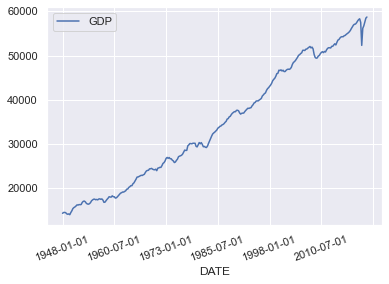

In [7]:
df_data.plot(x="DATE",y="GDP", rot=20);

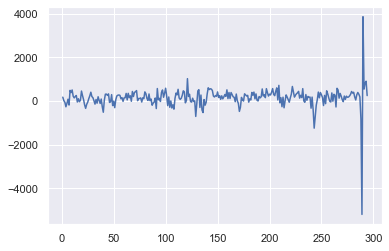

In [8]:
df_data["GDP"].diff().plot();

In [9]:
df_data["GDP"]=df_data["GDP"].diff()
df_data.dropna(inplace=True)

#Let's remove covid effect
df_data=df_data[df_data["DATE"]<"2020"]

df_data

,DATE,UNRATE,GDP
1,1948-04-01,3.9,179.0
2,1948-07-01,3.6,20.0
3,1948-10-01,3.7,-51.0
4,1949-01-01,4.3,-262.0
5,1949-04-01,5.3,-105.0
...,...,...,...
283,2018-10-01,3.8,51.0
284,2019-01-01,4.0,286.0
285,2019-04-01,3.7,394.0
286,2019-07-01,3.6,315.0


In [10]:
# We reject the null, hence it seems to be stationary. 
# The data we're using was already 'de-seasonalized'
adf_test(df_data["GDP"])

Results of Dickey-Fuller Test:
Test Statistic                  -5.260746
p-value                          0.000007
#Lags Used                      11.000000
Number of Observations Used    275.000000
Critical Value (1%)             -3.454355
Critical Value (5%)             -2.872108
Critical Value (10%)            -2.572401
dtype: float64


In [11]:
df_data.index=pd.to_datetime(df_data["DATE"])
df_data.drop("DATE",axis=1,inplace=True)

C:\Users\iavta\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [12]:
train = df_data.iloc[:-10,:]
test = df_data.iloc[-10:,:]

Check this [statsmodel page](https://www.statsmodels.org/dev/vector_ar.html?highlight=vector%20autoregressive%20model#vector-ar--page-root), for more information on how to model a VAR.

In [13]:
forecasting_model = VAR(train)

C:\Users\iavta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


In [14]:
results = forecasting_model.fit(maxlags=15, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 11, Dec, 2021
Time:                     13:30:20
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    8.75892
Nobs:                     275.000    HQIC:                   8.68018
Log likelihood:          -1956.68    FPE:                    5582.58
AIC:                      8.62740    Det(Omega_mle):         5384.98
--------------------------------------------------------------------
Results for equation UNRATE
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.432590         0.076456            5.658           0.000
L1.UNRATE         1.134905         0.060370           18.799           0.000
L1.GDP           -0.000515         0.000091           -5.676           0.00

In [15]:
pred_var=results.forecast(train.values[-2:], 10)
# -2 because we need initial values = nº of lags for VAR model

In [16]:
pred_var

array([[  4.46941495, 142.43074914],
       [  4.49352107, 120.10311057],
       [  4.58182513,  99.72976863],
       [  4.69905094,  91.647803  ],
       [  4.83004767,  89.0730686 ],
       [  4.96252055,  90.69254512],
       [  5.08928903,  94.67688831],
       [  5.20604175,  99.96972263],
       [  5.31064104, 105.79707318],
       [  5.4023666 , 111.66325092]])

In [19]:
cum_mse_var_unrate=[]
cum_mse_var_gdp=[]

for el in range(1,10):
    cum_mse_var_unrate.append(mse(test.iloc[:el,0].values,pred_var[:el,0]))
    cum_mse_var_gdp.append(mse(test.iloc[:el,1].values,pred_var[:el,1]))
    

In [20]:
cum_mse_var_gdp,cum_mse_var_unrate

([27413.176830102384,
  64554.20145929996,
  66669.41301036102,
  74549.45959833551,
  61799.72909253682,
  51762.35726678609,
  49596.95380970058,
  54204.06008491713,
  53044.2605856628],
 [0.02870142466502163,
  0.0917801300012797,
  0.17402691328612926,
  0.2526882397344922,
  0.41435023204613924,
  0.5705341992888238,
  0.6585365394111814,
  0.8597396892457576,
  1.0893566962064862])

So, we know that the best VAR model uses 2 lags for each equation.

Let's create the same variables, and see if we can improve our predictions with deep learning models.

In [21]:
df_data

,UNRATE,GDP
DATE,,
1948-04-01,3.9,179.0
1948-07-01,3.6,20.0
1948-10-01,3.7,-51.0
1949-01-01,4.3,-262.0
1949-04-01,5.3,-105.0
...,...,...
2018-10-01,3.8,51.0
2019-01-01,4.0,286.0
2019-04-01,3.7,394.0


In [22]:
df_l1=df_data.shift()
#df_l1.drop("DATE",axis=1,inplace=True)
df_l1.rename({"GDP":"GDP_L1","UNRATE":"UNRATE_L1"},axis=1,inplace=True)
df_l2=df_data.shift(2)
#df_l2.drop("DATE",axis=1,inplace=True)
df_l2.rename({"GDP":"GDP_L2","UNRATE":"UNRATE_L2"},axis=1,inplace=True)

In [23]:
data=pd.concat([df_data,df_l1,df_l2],axis=1).drop(df_data.index[0:2])
data

,UNRATE,GDP,UNRATE_L1,GDP_L1,UNRATE_L2,GDP_L2
DATE,,,,,,
1948-10-01,3.7,-51.0,3.6,20.0,3.9,179.0
1949-01-01,4.3,-262.0,3.7,-51.0,3.6,20.0
1949-04-01,5.3,-105.0,4.3,-262.0,3.7,-51.0
1949-07-01,6.7,85.0,5.3,-105.0,4.3,-262.0
1949-10-01,7.9,-183.0,6.7,85.0,5.3,-105.0
...,...,...,...,...,...,...
2018-10-01,3.8,51.0,3.8,193.0,4.0,405.0
2019-01-01,4.0,286.0,3.8,51.0,3.8,193.0
2019-04-01,3.7,394.0,4.0,286.0,3.8,51.0


In [24]:
train = data.iloc[:-10,:]
test = data.iloc[-10:,:]

In [25]:
x_train=train[["UNRATE_L1","GDP_L1","UNRATE_L2","GDP_L2"]][:-10].values

y_train=train[["UNRATE","GDP"]][:-10].values

x_val=train[["UNRATE_L1","GDP_L1","UNRATE_L2","GDP_L2"]][-10:].values
y_val=train[["UNRATE","GDP"]][-10:].values

x_test=test[["UNRATE_L1","GDP_L1","UNRATE_L2","GDP_L2"]].values
y_test=train[["UNRATE","GDP"]].values

In [26]:
# inputs: A 3D tensor, with shape [batch, timesteps, feature].
# batch = sample size,
# timesteps = This is where previous steps in the sequence are provided as additional 
# input features to the network
# feature = nº of features

# Since, we've already added the lags to the df, we use timesteps=1
x_train_2=np.reshape(x_train,(265,1,4))
x_val_2=np.reshape(x_val,(10,1,4))
x_test_2=np.reshape(x_test,(10,1,4))

In [27]:
model=models.Sequential([layers.SimpleRNN(100,input_shape=(None,4),
                                          return_sequences=True,
                                          #kernel_initializer='lecun_normal',
                                          activation='relu'),
                         layers.SimpleRNN(100,return_sequences=True,
                                          kernel_initializer='lecun_normal',
                                          activation='selu'),
                         layers.SimpleRNN(2,activation=None),
                         # default activation function is tanh which belongs to ]-1,1[
                         
                        ])

model.compile(optimizer="Adam",
              loss=['mse'], #tf.keras.losses.MeanSquaredError(),
             metrics=["mae"])


In [28]:
#keras.utils.plot_model(model,show_shapes=True)

In [29]:
history=model.fit(x_train_2,y_train,
                 epochs=20,
                 validation_data=(x_val_2,y_val),
                 verbose=1)

Epoch 1/20
9/9 [==============================] - 5s 172ms/step - loss: 43464.0156 - mae: 127.8180 - val_loss: 7213.9829 - val_mae: 60.1515
Epoch 2/20
9/9 [==============================] - 1s 91ms/step - loss: 31899.7852 - mae: 102.6382 - val_loss: 6086.4688 - val_mae: 48.5830
Epoch 3/20
9/9 [==============================] - 1s 88ms/step - loss: 32047.3047 - mae: 101.1593 - val_loss: 5979.9541 - val_mae: 44.8621
Epoch 4/20
9/9 [==============================] - 1s 84ms/step - loss: 31160.5645 - mae: 98.2972 - val_loss: 6410.6562 - val_mae: 50.7426
Epoch 5/20
9/9 [==============================] - 0s 24ms/step - loss: 30946.7930 - mae: 98.0841 - val_loss: 6536.5376 - val_mae: 52.0983
Epoch 6/20
9/9 [==============================] - 0s 9ms/step - loss: 30724.3926 - mae: 98.3682 - val_loss: 6185.7358 - val_mae: 48.9269
Epoch 7/20
9/9 [==============================] - 0s 9ms/step - loss: 30564.9434 - mae: 98.3798 - val_loss: 6360.7373 - val_mae: 51.1364
Epoch 8/20
9/9 [================

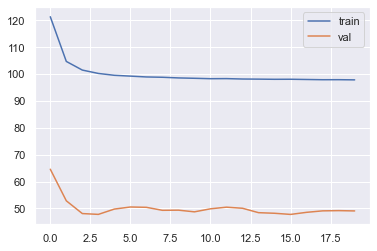

In [37]:
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.legend()
plt.show()

Depending on our model, this is could be worrisome or not...
Here, we have a small data set, and the validation set may have an easier to predict sample than the training set.

In [31]:
pred_dl=model.predict(x_test_2)
pred_dl

array([[  6.560439 , 150.28099  ],
       [  7.5192356, 195.1472   ],
       [  9.534199 , 272.59863  ],
       [  9.184567 , 269.08258  ],
       [ 10.12653  , 255.18205  ],
       [  9.2415085, 205.76103  ],
       [  6.8786445,  94.70959  ],
       [  4.123363 , 160.51762  ],
       [  8.902508 , 245.73975  ],
       [  8.593745 , 239.12206  ]], dtype=float32)

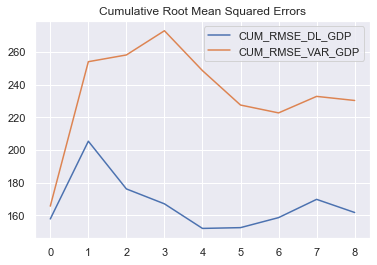

In [32]:
cum_mse_dl_unrate=[]
cum_mse_dl_gdp=[]

for el in range(1,10):
    cum_mse_dl_unrate.append(mse(test.iloc[:el,0].values,pred_dl[:el,0]))
    cum_mse_dl_gdp.append(mse(test.iloc[:el,1].values,pred_dl[:el,1]))

dic_gdp = {'CUM_RMSE_DL_GDP':np.sqrt(cum_mse_dl_gdp) , 
           'CUM_RMSE_VAR_GDP': np.sqrt(cum_mse_var_gdp)}
df_cum_gdp=pd.DataFrame(dic_gdp)

df_cum_gdp.plot(title="Cumulative Root Mean Squared Errors")
plt.show;

Clearly the simple Deep Learning model wins...

In [33]:
model2=models.Sequential([layers.SimpleRNN(100,input_shape=(None,4),
                                          return_sequences=True,
                                          #kernel_initializer='lecun_normal',
                                          activation='relu'),
                         layers.SimpleRNN(100,return_sequences=True,
                                          kernel_initializer='lecun_normal',
                                          activation='selu'),
                         layers.SimpleRNN(2,activation=None),
                         # default activation function is tanh which belongs to ]-1,1[
                         
                        ])

opt=tf.keras.optimizers.Adamax(
    learning_rate=0.001)

model2.compile(optimizer=opt,
              loss=['mse'], #tf.keras.losses.MeanSquaredError(),
             metrics=["mae"])

In [34]:
history=model2.fit(x_train_2,y_train,
                 epochs=20,
                 validation_data=(x_val_2,y_val),
                 verbose=0)

In [35]:
pred_dl2=model2.predict(x_test_2)
pred_dl2

array([[  5.597922 , 140.40668  ],
       [  5.981383 , 182.0336   ],
       [  6.1874175, 252.65686  ],
       [  7.130977 , 260.4285   ],
       [  7.9267   , 247.19377  ],
       [  4.446983 , 203.86021  ],
       [  2.555485 ,  91.96017  ],
       [  7.0833077, 144.02774  ],
       [  6.2684608, 228.83844  ],
       [  6.330833 , 231.01428  ]], dtype=float32)

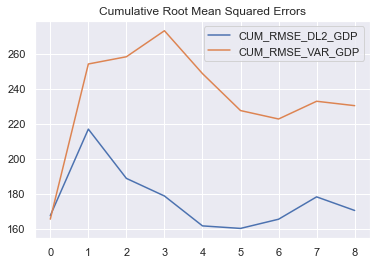

In [36]:
cum_mse_dl2_unrate=[]
cum_mse_dl2_gdp=[]

for el in range(1,10):
    cum_mse_dl2_unrate.append(mse(test.iloc[:el,0].values,pred_dl2[:el,0]))
    cum_mse_dl2_gdp.append(mse(test.iloc[:el,1].values,pred_dl2[:el,1]))

dic2_gdp = {'CUM_RMSE_DL2_GDP':np.sqrt(cum_mse_dl2_gdp) , 
           'CUM_RMSE_VAR_GDP': np.sqrt(cum_mse_var_gdp)}
df2_cum_gdp=pd.DataFrame(dic2_gdp)

df2_cum_gdp.plot(title="Cumulative Root Mean Squared Errors")
plt.show;

We've improved a bit.